## Imports

In [1]:
import numpy as np
import sympy as sp
import itertools as it
from functools import partial
from joblib import Parallel, delayed
from typing import Sequence, Tuple, Dict, List
import os
import time
import poly2graph as p2g
import pickle
from multiprocessing.pool import ThreadPool
import glob
from NHSG12M import NHSG12M
import matplotlib.pyplot as plt
import networkx as nx

c:\Users\15256\anaconda3\envs\pyg\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\15256\anaconda3\envs\pyg\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\15256\anaconda3\envs\pyg\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


## Class `NHSG12M`

The `NHSG12M` is a helper class for building and managing **Non-Hermitian spectral graph datasets**. It provides methods to

- construct characteristic polynomials of varying complexity (giving unique instances by removing duplicates them based on symmetry),  
- generate full datasets by sweeping parameter values,  
- export a master parameter table, and 
- filter and combine dataset partitions.

---

### 1. Attributes

| Name               | Type                    | Description                                                                             |
|--------------------|-------------------------|-----------------------------------------------------------------------------------------|
| `z`                | `sp.Symbol`             | Symbol for the complex variable \(z = $e^{iK}$\).                                         |
| `E`                | `sp.Symbol`             | Symbol for the energy variable \(E\).                                                   |
| `hopping_ranges`   | `List[int]`             | One or more integer hopping ranges(m) in z = $e^{imK}$ to explore different polynomial degrees.       |
| `params`           | `Tuple[sp.Symbol, ...]` | Sequence of free-parameter symbols (e.g. \(`a`, `b`\)) for the selected hoppings.                                 |
| `max_num_bands`    | `int`                   | Maximum exponent on the energy terms (highest band index \(b\)).                        |
| `n_jobs`           | `int`                   | Number of parallel workers for costly computations (`-1` uses all CPU cores).           |


### 2. Inner Methods

| Method | Purpose |
|--------|---------|
| `generate_char_poly_classes()` | Enumerates all polynomials for every `m` of $z = e^{imK}$ in `hopping_ranges`, removes duplicates, and returns sympy expressions and their metadata information i.e`(exprs, metas)`. |
| `generate_ParamTable(file, exprs, metas, real_walk, imag_walk)` (helper function) | Builds a master parameter table with every ordered pair of complex coefficients to use it in `combine_class_parts(metas, …)` function. It works by accepting imaginary (`imag_walk`) and real (`real_walk`) parts of the coefficients, and creates a grid of every possible combination of these values. Then, it varies each free parameter (`a`, `b`) while generating the dataset using `generate_dataset(class_idx, …)`|
| `generate_dataset(class_idx, …)` | Sweeps parameter grids, calculates the each polynomial to identify the graphs, and saves partitioned `.npz` files. |
| `filter_metas(metas, …)` (helper function) | Returns a list of *indices* whose metadata match the supplied criteria. |
| `combine_class_parts(metas, …)` | Merges many individually created `class_<cid>_part_*.npz` files by selecting according to given criteria, filtering the parameters by the helper function filter_metas. |
 

---

### 3. Contents of a **`meta`** Dictionary

Every polynomial returned by `generate_char_poly_classes()` is paired with a
metadata dictionary that captures both its **symbolic structure** and all
integer parameters needed for later filtering.  The keys are:

| Key | Type | Meaning |
|-----|------|---------|
| `parameter_symbols` | `Tuple[str, …]` | Names of the free coefficients inserted into the polynomial (e.g. `('a', 'b')`). |
| `generator_symbols` | `Tuple[str, …]` | The SymPy generator ordering used inside `sp.Poly` — normally `('z', '1/z', 'E')`. |
| `latex` | `str` | LaTeX code for the fully-expanded polynomial (ready for `\\( … \\)` embedding). |
| `sympy_repr` | `str` | Result of `sp.srepr(poly)` – a machine-readable AST for exact reconstruction. |
| `number_of_bands` | `int` | Band index \(b\) (= highest exponent of `E` in the base term `-E**b`). |
| `max_left_hopping` | `int` | Positive exponent \(q\) in the base term `z**q`. |
| `max_right_hopping` | `int` | Complementary exponent \(p = D - q\) in the base term `z**(-p)`. |
| `intermediate_z_degrees` | `Tuple[int, …]` | All non-zero \(z\)-exponents that lie **between** `-p` and `q` (excluding end-caps). |
| `E_deg_assignments` | `Tuple[int, …]` | For each intermediate exponent, the power of `E` that multiplies it (`0` ⇒ no `E`). |
| `param_degree_placements` | `Tuple[int, …]` | Subset of `intermediate_z_degrees` that host *parameter symbols* instead of unit coefficients. |

---


In [2]:
# 1. Define the core symbols for your polynomial
#    - `z` represents the complex phase factor: z = exp(iK)
#    - `E` is the energy variable appearing in the characteristic polynomial
z, E = sp.symbols('z E')

# 2. Specify the two parameter symbols to be inserted in extra terms
#    These symbolic parameters (e.g., `a`, `b`) will later be replaced by real/imaginary values
params = (sp.symbols('a'), sp.symbols('b'))

# 3. Instantiate the creator to generate characteristic polynomials
#    - hopping_range=[4, 5] includes hopping terms up to z^±4 and z^±5, which define graph connectivity
#    - max_num_bands=3 restricts the highest power of energy E to E³, resulting in up to 3 energy bands
#    This setup defines the polynomial structure used to encode graph spectra.
creator = NHSG12M(
    z=z,
    E=E,
    hopping_range=[4, 5, 6],
    params=params,
    num_bands=[1, 2, 3],
)

In [4]:
# 4. Generate unique characteristic polynomials and their metadata
#    This function systematically constructs all valid characteristic polynomials
#    based on the specified hopping ranges (e.g., z^±4, z^±5) and energy terms (e.g., −E, −E², −E³).
#    It returns:
#    - exprs: A list of SymPy expressions representing each unique polynomial
#    - metas: A list of dictionaries containing metadata (e.g., hopping degrees, band count, etc.)
exprs, metas = creator.generate_char_poly_classes()

# 5. Define the real and imaginary coefficient walks
#    These are the values over which the free parameters `a` and `b` will be swept.
real_coeff_walk = np.array([-10, -5, -2, -1, -0.5, -0.1, 
                      0, 0.1, 0.5, 1, 2, 5, 10])
imag_coeff_walk = 1j*np.array([-5, -2, -1, 0, 1, 2, 5])
# real_coeff_walk = [-0.2, 0.2]
# imag_coeff_walk = 1j * np.array([-0.5, 0.5])

# 6. Generate a parameter table by sweeping all combinations of real and imaginary coefficients
#    This creates a full parameter sweep grid, inserting each combination of (a, b) into every polynomial.
#    The resulting file includes:
#    - all parameterized polynomial expressions
#    - their associated metadata
#    - the actual a, b values used
#    It is saved to 'ParamTable.npz' for later use in dataset generation.
creator.generate_ParamTable(
    save_dir='./poly_class_dataset',
    file_name='ParamTable.npz',
    exprs=exprs,
    metas=metas,
    real_coeff_walk=real_coeff_walk,
    imag_coeff_walk=imag_coeff_walk
)

# 7. Generate datasets for each class index using the parameter table
#    For each class index i (corresponding to a distinct polynomial from exprs/metas),
#    this method:
#    - Loads all (a, b) values from 'ParamTable.npz'
#    - Substitutes them into the polynomial expression for class i
#    - Evaluates the graph structure from the resulting polynomial
#    - Splits the resulting graph data into `num_partition` parts for scalability
#    The resulting files are saved as:
#    ./poly_class_dataset/class_<i>_part_<n>.npz
# for i in range(10): 
# # for i in range(len(metas)): 
#     print(f"=== Generating dataset for class {i}... ===")
#     creator.generate_dataset(
#         class_idx=i,
#         class_data='./poly_class_dataset/ParamTable.npz',
#         num_partition=2
#     )

[Hopping range = 4] raw samples: 42
[Hopping range = 4] unique samples: 15
[Hopping range = 5] raw samples: 432
[Hopping range = 5] unique samples: 162
[Hopping range = 6] raw samples: 2940
[Hopping range = 6] unique samples: 1224


In [ ]:
# out = np.load('./poly_class_dataset/ParamTable.npz', allow_pickle=True)
# polys = out['polys']
# metas = out['metas']
# param1_vals, param2_vals = out['param_vals']

In [ ]:
data0 = np.load('./poly_class_dataset/class_0.npz', allow_pickle=True)
graphs_pickle = data0['graphs_pickle']
graphs_pickle = [pickle.loads(g) for g in graphs_pickle]
a_vals = data0['a_vals']
b_vals = data0['b_vals']
sympy_repr = data0['sympy_repr'].item()

In [ ]:
# 8. Combine partitioned dataset files that match specific metadata and parameter filters
#    This function merges multiple class_<id>_part_<n>.npz files into a single dataset.
#    It allows fine-grained filtering over various polynomial characteristics.

#    - metas: A list of metadata dictionaries for the polynomial expressions.
#             Use slicing (e.g., metas[:10]) to limit to selected expressions.
#    - input_dir: Directory where the partitioned class dataset files are stored.
#    - output_dir: Directory to save the combined output file.
#    - number_of_bands: If set, filters only polynomials with this number of energy bands (i.e., max power of −E).
#    - max_left_hopping: Filters polynomials with maximum negative hopping (i.e., max |negative z exponent|).
#    - max_right_hopping: Filters polynomials with maximum positive hopping (i.e., max z exponent).
#    - intermediate_z_degrees: Filters polynomials that contain specific non-extreme z-degrees (e.g., z⁰, z², etc.).
#    - E_deg_assignments: Allows filtering by the degrees assigned to energy terms (e.g., must contain −E²).
#    - a_vals_filter: Filters parameter values by selecting only datasets where 'a' is in this list.
#    - b_vals_filter: Filters parameter values by selecting only datasets where 'b' is in this list.

combined_path = creator.combine_class_parts(
    metas=metas,             # Only process the first 10 polynomial classes
    input_dir='poly_class_dataset',
    output_dir='./poly_class_dataset/',
    number_of_bands=3             # Only include polynomials with 2 energy bands (−E² max)
    # You can optionally add filters like:
    # max_left_hopping=3,
    # max_right_hopping=3,
    # intermediate_z_degrees=[0, 2],
    # E_deg_assignments=[2],
    # a_vals_filter=[-10, 10],
    # b_vals_filter=[-5, 5]
)

print("Combined file at:", combined_path)

In [ ]:
# Creating the collections provided within the dataset
OutDir="Subsets"
os.makedirs(f'./{OutDir}', exist_ok=True)
# 1a) E_band = 1
combined_path = creator.combine_class_parts(
    metas=metas,
    input_dir='poly_class_dataset',
    output_dir=f'./{OutDir}/',
    number_of_bands=1
)
print("Combined E_band=1 file at:", combined_path)

# 1b) E_band = 2
combined_path = creator.combine_class_parts(
    metas=metas,
    input_dir='poly_class_dataset',
    output_dir=f'./{OutDir}/',
    number_of_bands=2
)
print("Combined E_band=2 file at:", combined_path)

# 1c) E_band = 3
combined_path = creator.combine_class_parts(
    metas=metas,
    input_dir='poly_class_dataset',
    output_dir=f'./{OutDir}/',
    number_of_bands=3
)
print("Combined E_band=3 file at:", combined_path)

# 2) Sparse Dataset
combined_path = creator.combine_class_parts(
    metas=metas,
    input_dir='poly_class_dataset',
    output_dir=f'./{OutDir}/',
    a_vals_filter=[-10],
    b_vals_filter=[-5]
)
print("Combined SG_clean file at:", combined_path)

# 3) Temporal Dataset
combined_path = creator.combine_class_parts(
    metas=metas,
    input_dir='poly_class_dataset',
    output_dir=f'./{OutDir}/',
    a_vals_filter=[-10],      # fix a = –10
    b_vals_filter=[-5, 5]     # sweep b over –5 and +5
)
print("Combined temporal spectral graph dataset file at:", combined_path)


Combined E_band=1 file at: ./Subsets/classes_combined_number_of_bands_1.npz
Combined E_band=2 file at: ./Subsets/classes_combined_number_of_bands_2.npz
Combined E_band=3 file at: ./Subsets/classes_combined_number_of_bands_3.npz
Combined SG_clean file at: ./Subsets/classes_combined_a_-10_b_-5.npz
Combined temporal spectral graph dataset file at: ./Subsets/classes_combined_a_-10_b_-5_5.npz


## Loading Files

### 4. Contents of the **`ParamTable.npz`** File

The `ParamTable.npz` file stores all the information needed to reconstruct and sweep parameterized polynomials. It includes the following keys:

| Key | Type | Meaning |
|-----|------|---------|
| `polys` | `List[sympy.Expr]` | List of symbolic polynomial expressions corresponding to polynomial classes, each parameterized by coefficients (e.g., `a`, `b`). |
| `metas` | `List[Dict]` | Metadata dictionary for each polynomial, detailing symbolic structure, hopping range, and coefficient locations. See [above](#3-contents-of-a-meta-dictionary) for structure. |
| `param_vals` | `List[np.ndarray]` | Parameter grid values for each free parameter. For instance, `param_vals[0]` stores all values for parameter `a`, `param_vals[1]` for `b`. These arrays are **aligned by index**, meaning the `i`-th entries in `a_vals` and `b_vals` form the `(a, b)` pair used in the `i`-th polynomial evaluation. |
 
**Note:** `polys` and `metas` share the same index order; that is, `metas[index]` corresponds to the metadata of the polynomial in `polys[index]`.


In [14]:
# Load the parameter table generated previously
param_table = np.load('./poly_class_dataset/ParamTable.npz', allow_pickle=True)

# Extract stored contents
polys       = param_table['polys']        # list of parameterized SymPy polynomial expressions
metas       = param_table['metas']        # list of metadata dicts for each polynomial
param_vals  = param_table['param_vals']   # list of arrays for each parameter (e.g., a_vals, b_vals) 

# Print the first 5 polynomials and their metadata
print("=== First 3 polynomials in the parameter table and their metadata ===\n")
for i in range(3):
    print(f"[{i+1}] Polynomial:\n  {polys[i]}")
    print(f"    Metadata:\n  {metas[i]}\n")

# Print the ranges over which the free parameters are swept
print("=== Parameter Sweeps ===")
print(f"1st free parameter (a) runs over: {param_vals[0]}")
print(f"2nd free parameter (b) runs over: {param_vals[1]}")
print("Note: They simultaneously run over the same indices, forming the used (a, b) pairs.")


=== First 3 polynomials in the parameter table and their metadata ===

[1] Polynomial:
  -E + a/z**2 + b/z + z + z**(-3)
    Metadata:
  {'parameter_symbols': ('a', 'b'), 'generator_symbols': ('z', '1/z', 'E'), 'latex': '- E + \\frac{a}{z^{2}} + \\frac{b}{z} + z + \\frac{1}{z^{3}}', 'sympy_repr': "Poly(Add(Mul(Integer(-1), Symbol('E')), Mul(Symbol('a'), Pow(Symbol('z'), Integer(-2))), Mul(Symbol('b'), Pow(Symbol('z'), Integer(-1))), Symbol('z'), Pow(Symbol('z'), Integer(-3))), Symbol('z'), Pow(Symbol('z'), Integer(-1)), Symbol('E'))", 'number_of_bands': 1, 'max_left_hopping': 1, 'max_right_hopping': 3, 'intermediate_z_degrees': (-2, -1), 'E_deg_assignments': (0, 0), 'param_degree_placements': (-2, -1)}

[2] Polynomial:
  -E**2 + E*b/z + a/z**2 + z + z**(-3)
    Metadata:
  {'parameter_symbols': ('a', 'b'), 'generator_symbols': ('z', '1/z', 'E'), 'latex': '- E^{2} + \\frac{E b}{z} + \\frac{a}{z^{2}} + z + \\frac{1}{z^{3}}', 'sympy_repr': "Poly(Add(Mul(Integer(-1), Pow(Symbol('E'), Integ

### 5. Contents of the **`class_<id>_part_<n>.npz`** Files

Each partitioned `.npz` file stores spectral graph data generated from a **single polynomial class** and a specific **chunk of parameter values**. These files are created by the `generate_dataset(...)` method and are named as: `class_<class_index>part<partition_number>.npz`. This structure enables memory-efficient storage and parallel dataset construction.

| Key             | Type            | Meaning |
|------------------|------------------|---------|
| `graphs_pickle` | `List[bytes]`    | List of **pickled NetworkX graph objects**, each corresponding to a unique `(a, b)` parameter pair. |
| `a_vals`        | `np.ndarray`     | List of parameter values for `a` used in this partition. |
| `b_vals`        | `np.ndarray`     | List of parameter values for `b` used in this partition. |

**Note:** All arrays are **aligned by index**, i.e., the \(i\)-th graph in `graphs_pickle` was generated using `a = a_vals[i]` and `b = b_vals[i]`.

---

### 6. Contents of the **Combined `.npz` File**

Combined dataset files are generated using the `combine_class_parts(...)` method. They merge multiple class/partition outputs into a single file for simplified analysis or training workflows. The default name is: `classes_combined_a_<...>b<...>.npz`, if `a` and `b` are not specified just `classes_combined.npz`. 

| Key             | Type            | Meaning |
|------------------|------------------|---------|
| `graphs_pickle` | `List[bytes]`    | Pickled NetworkX graphs from multiple classes and parameter combinations. |
| `a_vals`        | `np.ndarray`     | The `a` parameter values for each graph in the combined dataset. |
| `b_vals`        | `np.ndarray`     | The `b` parameter values for each graph in the combined dataset. |
| `metas`| `List[Dict]` | Metadata associated with each graph’s originating polynomial class. Useful for class-level grouping or filtering. |

**Note:** All arrays are **aligned by index**, i.e., the \(i\)-th graph in `graphs_pickle` was generated using `metas[i]`, `a = a_vals[i]` and `b = b_vals[i]`.



In [52]:
# 1. Set the class index and partition number you want to inspect
#    - class_index refers to the polynomial class (e.g., class_0)
#    - partition_number refers to which split file among the 10 parts you want to view
class_index = 0
partition_number = 1

# 2. Construct the file path for the corresponding .npz dataset file
file_path = f'poly_class_dataset/class_{class_index}_part_{partition_number}.npz'

# 3. Load the .npz file containing pickled graphs and their parameter values
#    allow_pickle=True is necessary since graphs are stored as pickled NetworkX objects
data = np.load(file_path, allow_pickle=True)

# 4. Extract arrays from the file
#    - graphs_pickle: contains pickled NetworkX graph objects
#    - a_vals: the 'a' parameter values used for each graph
#    - b_vals: the 'b' parameter values used for each graph
graphs_pickle = data['graphs_pickle']
a_vals = data['a_vals']
b_vals = data['b_vals']

# 5. Unpickle the first 2 graph objects to inspect their structure
#    (you can change the range to display more if desired)
graphs = [pickle.loads(g) for g in graphs_pickle]

print(f"Number of graphs in the {class_index + 1}st class's partitioned file (partition {partition_number}): {len(graphs)}.\n")

# 6. Display the parameters and structural information of each graph
#    This includes the parameter values used and the full node/edge structure
print(f"=== First 2 entries in '{file_path}' ===\n")
print(f"-Corresponding polynomial class {polys[class_index]}-")
print(f"-Corresponding metadata {metas[class_index]}-\n")

for i in range(2):
    print(f"[{i+1}] a = {a_vals[i]}, b = {b_vals[i]}")
    print(f"     Nodes: {graphs[i].nodes(data=True)}")
    print(f"     Edges: {graphs[i].edges(data=True)}\n")


Number of graphs in the 1st class's partitioned file (partition 1): 2.

=== First 2 entries in 'poly_class_dataset/class_0_part_1.npz' ===

-Corresponding polynomial class -E + a/z**2 + b/z + z + z**(-3)-
-Corresponding metadata {'parameter_symbols': ('a', 'b'), 'generator_symbols': ('z', '1/z', 'E'), 'latex': '- E + \\frac{a}{z^{2}} + \\frac{b}{z} + z + \\frac{1}{z^{3}}', 'sympy_repr': "Poly(Add(Mul(Integer(-1), Symbol('E')), Mul(Symbol('a'), Pow(Symbol('z'), Integer(-2))), Mul(Symbol('b'), Pow(Symbol('z'), Integer(-1))), Symbol('z'), Pow(Symbol('z'), Integer(-3))), Symbol('z'), Pow(Symbol('z'), Integer(-1)), Symbol('E'))", 'number_of_bands': 1, 'max_left_hopping': 1, 'max_right_hopping': 3, 'intermediate_z_degrees': (-2, -1), 'E_deg_assignments': (0, 0), 'param_degree_placements': (-2, -1)}-

[1] a = (0.2-0.5j), b = (-0.2-0.5j)
     Nodes: [(0, {'pos': array([ 0.27281179, -1.60743388]), 'dos': np.float32(0.24261908), 'potential': np.float32(-0.24431077)}), (3, {'pos': array([ 0.34582

In [55]:
print("Combined file at:", combined_path)
# 2. Load the combined .npz file that stores graphs and parameter values
data = np.load(combined_path, allow_pickle=True)

# 3. Extract the arrays from the combined file
#    - graphs_pickle: pickled NetworkX graph objects
#    - a_vals: values used for the free parameter 'a'
#    - b_vals: values used for the free parameter 'b'
#    - (Optional) class_indices or metas may also be included depending on the implementation
graphs_pickle = data['graphs_pickle']
a_vals = data['a_vals']
b_vals = data['b_vals'] 
metas = data['metas'] 
graphs = [pickle.loads(g) for g in graphs_pickle]
print(f'Number of graphs in the combined file: {len(graphs)}.\n')
# 5. Display the parameters and structural information of each graph
 
print(f"\n=== First 2 entries in '{combined_path}' ===\n")
for i in range(2):
    print(f"[{i+1}] meta data: {metas[i]}\n")
    print(f"a = {a_vals[i]}, b = {b_vals[i]}")
    print(f"     Nodes: {graphs[i].nodes(data=True)}")
    print(f"     Edges: {graphs[i].edges(data=True)}\n")


Combined file at: ./classes_combined.npz
Number of graphs in the combined file: 48.


=== First 2 entries in './classes_combined.npz' ===

[1] meta data: {'parameter_symbols': ('a', 'b'), 'generator_symbols': ('z', '1/z', 'E'), 'latex': '- E^{2} + \\frac{E b}{z} + \\frac{a}{z^{2}} + z + \\frac{1}{z^{3}}', 'sympy_repr': "Poly(Add(Mul(Integer(-1), Pow(Symbol('E'), Integer(2))), Mul(Symbol('E'), Symbol('b'), Pow(Symbol('z'), Integer(-1))), Mul(Symbol('a'), Pow(Symbol('z'), Integer(-2))), Symbol('z'), Pow(Symbol('z'), Integer(-3))), Symbol('z'), Pow(Symbol('z'), Integer(-1)), Symbol('E'))", 'number_of_bands': 2, 'max_left_hopping': 1, 'max_right_hopping': 3, 'intermediate_z_degrees': (-2, -1), 'E_deg_assignments': (0, 1), 'param_degree_placements': (-2, -1)}

a = (-0.2-0.5j), b = (-0.2-0.5j)
     Nodes: [(0, {'pos': array([ 0.18043636, -1.2107704 ]), 'dos': np.float32(0.24882457), 'potential': np.float32(-0.3113408)}), (3, {'pos': array([-1.21388442, -0.92542431]), 'dos': np.float32(0.0016

## 7. Node and Edge Attributes of the Spectral Graph Object

Each spectral graph is represented as a `networkx.MultiGraph` object.  
The nodes and edges of this graph encode spectral information derived from the characteristic polynomial over complex energy values.

---

#### Node Attributes

| Attribute | Type              | Description |
|-----------|-------------------|-------------|
| `pos`     | `(2,) np.ndarray` | 2D position of the node in the complex energy plane, given as \((\text{Re}(E), \text{Im}(E))\). |
| `dos`     | `float`           | Local **density of states** at the node, indicating the number of spectral roots in the vicinity. |
| `potential` | `float`         | Local **spectral potential**, which can be interpreted as an energy-dependent quantity derived from the eigenstructure. |

---

#### Edge Attributes

| Attribute | Type                | Description |
|-----------|---------------------|-------------|
| `weight`  | `float`             | Length of the edge in the complex energy plane, i.e., the Euclidean distance between its endpoints. |
| `pts`     | `(w, 2) np.ndarray` | Discretized points along the edge, forming a path in the complex plane. `w` is the number of samples along the edge. |
| `avg_dos` | `float`             | Average density of states sampled along the edge trajectory. |
| `avg_potential` | `float`       | Average spectral potential sampled along the edge trajectory. |

---

These attributes provide the necessary information to analyze and visualize the spectral topology of each polynomial class, including localization patterns, spectral gaps, and branch connectivity in the complex energy domain.


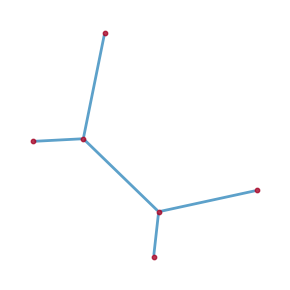

In [45]:
ind=0
G=graphs[ind]
fig, ax = plt.subplots(figsize=(3, 3))
pos_multi = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos_multi, ax=ax, 
        node_size=10, node_color='#A60628', 
        edge_color='#348ABD', width=2, alpha=0.8)
plt.tight_layout() 
plt.show()